In [2]:
import matplotlib.pyplot as plt

# Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True
plt.gray()

import numpy as np
import pandas as pd

# 11. Measuring performance in Classification Models

We now turn our focus to building and evaluating models for a categorical response. Although many of the regression modeling techniques can also be used for classification, the way we evaluate model performance is necessarily very different since metrics like RMSE and $R^2$ are not appropriate in the context of classification. We will take an in-depth look at the different aspects of classification model predictions and how these relate to the question of interest.

## 11.1 Class Predictions

Classification models usually generate two types of predictions. Like regression models, classification models produce a continuous valued prediction, which is usually in the form of a probability (i.e., the predicted values of class membership for any individual sample are between 0 and 1 and sum to 1). In addition to a continuous prediction, classification models generate a predicted class, which comes in the form of a discrete category. For most practical applications, a discrete category prediction is required in order to make a decision.

Although classification models produce both of these types of predictions, often the focus is on the discrete prediction rather than the continuous prediciton. However, the probability estimates for each class can be very useful for gauging the model's confidence about the predicted classification. For example, an email message with a predicted probability of being spam of 0.51 would be classified the same as a message with a predicted probability of being spam of 0.99. While both messages would be treated the same by the filter, we would have more confidence that the second message was truly spam. 

In some applications, the desired outcome is the predicted class probabilities which are then used as inputs for other calculations. Consider an insurance company that wants to uncover and prosecute fraudulent claims. Using historical claims data, a classification model could be built to predict the probability of claim fraud. This probability would then be combined with the company's investigation costs and potential monetary loss to determine if pursuing the investigation is in the best financial interest of the insurance company.

As mentioned, most classification models generate predicted class probabilities. However, when some models are used for classification, like neural networks and partial least squares, they produce continuous predictions that do not follow the definition of a probability. For example, a partial least squares classification model would ceate 0/1 dummy variables for each class and simultaneously model these values as a function of the predictors. When samples are predicted, the model predictions are not guaranteed to be within 0 and 1. For classification models like these, a transformation must be used to coerce the predictions into "probability-like" values so that they can be interpreted and used for classification. One such method is the *softmax transformation* 
$$\hat{p}_l^{*} = {e^{\hat{y}_l} \over \sum_{j=1}^C e^{\hat{y}_j}}$$
where $\hat{y}_l$ is the numeric model prediciton for the $l^{\text{th}}$ class and $\hat{p}_l^{*}$ is the transformed value between 0 and 1. To be clear, no probability statement is being created by this transformation; it merely ensures that the predictions have the same mathematical qualities as probabilities.

### Well-Calibrated Probabilities

Whether a classification model is used to predict spam email, or as inputs to insurance fraud, we desire that the estimated class probabilities are reflective of the true underlying probability of the sample. That is, the predicted class probability needs to be well-calibrated. To be well-calibrated, the probabilities must effectively reflect the true likelihood of the event of interest.

One way to assess the quality of the class probabilities is using a calibration plot. For a given set of data, this plot shows some measure of the observed probability of an event versus the predicted class probability. One approach for creating this visualization is to score a collection of samples with known outcomes (preferably a test set) using a classification model. The next step is to bin the data into groups based on their class probabilities. For example, a set of bins might be [0, 10%], (10%, 20%], ..., (90%, 100%]. For each bin, determine the observed event rate. Suppose that 50 samples fell into the bin for class probabilities less than 10% and there was a single event. The midpoint of the bin is 5% and the observed event rate would be 2%. The calibration plot would display the midpoint of the bin on the x-axis and the observed event rate on the y-axis. If the points fall along a $45^{\circ}$ line, the model has produced well-calibrated probabilities.

To illustrate, a data set was simulated. For classes (1 and 2) and two predictors (A and B), the true probability (p) of the event is generated from the equation $$log({p \over 1 - p}) = -1 - 2A - 0.2A^2 + 2B^2$$

In [3]:
# simulate two data sets
def simu_prob(A, B):
    return np.exp(-1 - 2*A - 0.2*A**2 + 2*B**2)/(1 + np.exp(-1 - 2*A - 0.2*A**2 + 2*B**2))

np.random.seed(3)

X_train = np.random.multivariate_normal(mean = [1.0, 0.0], cov = [[1.0, 0.7], [0.7, 2.0]], size = 500)
Y_train = np.array([np.random.binomial(1, simu_prob(x[0], x[1])) for x in X_train])

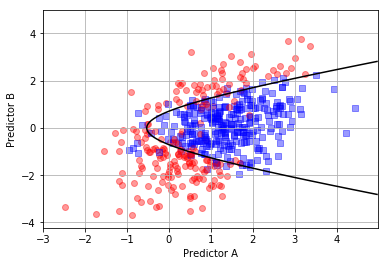

In [4]:
colors = ['b', 'r']
markers = ['s', 'o']

for idx, i in enumerate(Y_train):
    plt.scatter(X_train[idx, 0], X_train[idx, 1], 
                c = colors[i], marker= markers[i], 
                alpha = 0.4, s = 36)
plt.xlabel("Predictor A")
plt.ylabel("Predictor B")

# solid black line denotes the 50% probability contour
delta = 0.025
x = np.arange(-3.0, 5.0, delta)
y = np.arange(-3.0, 5.0, delta)
X, Y = np.meshgrid(x, y)
Z = simu_prob(X, Y)
plt.contour(x, y, Z, levels = [0.5])

Two models were fit to the training set: quadratic discriminant analysis and a random forest model. A test set of $n = 1000$ samples was used to score the model and create the calibration plot.

In [11]:
np.random.seed(5)

X_test = np.random.multivariate_normal(mean = [1.0, 0.0], cov = [[1.0, 0.7], [0.7, 2.0]], size = 1000)
Y_test = np.array([np.random.binomial(1, simu_prob(x[0], x[1])) for x in X_test])

In [12]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier

qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, Y_train)

print("Predictive accuracy of QDA: {0}".format(qda.score(X_test, Y_test)))

rf = RandomForestClassifier(n_estimators=1000, max_depth=5)
rf.fit(X_train, Y_train)
print("Predictive accuracy of Random Forest: {0}".format(rf.score(X_test, Y_test)))

Predictive accuracy of QDA: 0.865
Predictive accuracy of Random Forest: 0.864


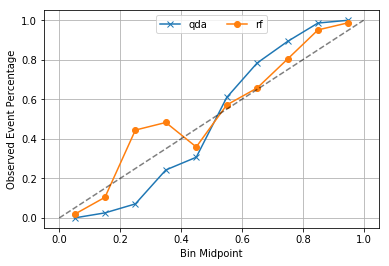

In [13]:
qda_predict = qda.predict_proba(X_test)[:, 1]
rf_predict = rf.predict_proba(X_test)[:, 1]

# calibration plot
# predict_prob = simu_prob(X_test[:, 0], X_test[:, 1])
calib_counts = np.zeros([2, 10])

for i in range(0, 10):
    calib_counts[0, i] = np.mean(Y_test[(qda_predict > i*0.1) * (qda_predict < (i+1)*0.1)])
    calib_counts[1, i] = np.mean(Y_test[(rf_predict > i*0.1) * (rf_predict < (i+1)*0.1)])
    
plt.plot(np.arange(0.05, 1.0, 0.1), calib_counts[0, :], 'x-', label = 'qda')
plt.plot(np.arange(0.05, 1.0, 0.1), calib_counts[1, :], 'o-', label = 'rf')
plt.xlabel('Bin Midpoint')
plt.ylabel('Observed Event Percentage')
plt.legend(loc = 'upper center', ncol = 2)
plt.plot([0, 1], [0, 1], 'k--', alpha = 0.5)

The calibration plot shows that the QDA class probabilities tend to perform poorly compared to the random forest model. For example, in the bin with class probabilities ranging from 20% to 30%, the observed percentage of events for QDA was far lower than the percentage in the random forest model.

### Presenting Class Probabilities

Visualizations of the class probabilities are an effective method of communicating model results. For two classes, histograms of the predicted classes for each of the true outcomes illustrate the strengths and weaknesses of a model. In Chapter 4, we introduced the credit scoring example. Two classification models were created to predict the quality of a customer's credit: a support vector machine (SVM) and logistic regression. Since the performance of the two models were roughly equivalent, the logistic regression model was favored due to its simplicity.

In [16]:
germancredit = pd.read_csv("datasets/GermanCredit.csv")
#germancredit.drop('Unnamed: 0', axis=1, inplace = True) # drop the first column
germancredit.head(5);

,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,credit_risk
0,... < 100 DM,6,critical account/other credits existing,domestic appliances,1169,unknown/no savings account,... >= 7 years,4,male : single,none,...,real estate,67,none,own,2,skilled employee/official,1,yes,yes,1
1,0 <= ... < 200 DM,48,existing credits paid back duly till now,domestic appliances,5951,... < 100 DM,1 <= ... < 4 years,2,female : divorced/separated/married,none,...,real estate,22,none,own,1,skilled employee/official,1,no,yes,0
2,no checking account,12,critical account/other credits existing,retraining,2096,... < 100 DM,4 <= ... < 7 years,2,male : single,none,...,real estate,49,none,own,1,unskilled - resident,2,no,yes,1
3,... < 100 DM,42,existing credits paid back duly till now,radio/television,7882,... < 100 DM,4 <= ... < 7 years,2,male : single,guarantor,...,building society savings agreement/life insurance,45,none,for free,1,skilled employee/official,2,no,yes,1
4,... < 100 DM,24,delay in paying off in the past,car (new),4870,... < 100 DM,1 <= ... < 4 years,3,male : single,none,...,unknown/no property,53,none,for free,2,skilled employee/official,2,no,yes,0


In [18]:
germancredit.groupby('credit_risk').count()


,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,present_residence,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker
credit_risk,,,,,,,,,,,,,,,,,,,,
0,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300
1,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700


In [21]:
# use stratified sampling to split training and test sets
def stratified_sampling(data, target, prop_train):
    '''a stratified random sampling based on proportion of the target outcomes.'''
    from collections import Counter
    
    n_class = dict(Counter(data[target]).items()) # frequency of possible outcomes
    data.reindex(np.random.permutation(data.index)) # random shuffle
    for key, val in n_class.items():
        n_train = np.int(val*prop_train)
        try:
            trainset = trainset.append(data[data[target] == key].iloc[:n_train,:], ignore_index=True)
            testset = testset.append(data[data[target] == key].iloc[n_train:, :], ignore_index=True)
        except NameError:
            trainset = data[data[target] == key].iloc[:n_train,:]
            testset = data[data[target] == key].iloc[n_train:, :]
        
    return trainset, testset
    
credit_train, credit_test = stratified_sampling(germancredit, 'credit_risk', 0.8)
print("The size of training set is %d and test set is %d"%(credit_train.shape[0],credit_train.shape[1]))


The size of training set is 800 and test set is 21


In [24]:
X_train = credit_train.drop('credit_risk', axis=1)
y_train = credit_train['credit_risk']
X_test = credit_test.drop('credit_risk', axis=1)
y_test = credit_test['credit_risk']

X_train

,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,present_residence,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker
0,... < 100 DM,6,critical account/other credits existing,domestic appliances,1169,unknown/no savings account,... >= 7 years,4,male : single,none,4,real estate,67,none,own,2,skilled employee/official,1,yes,yes
1,no checking account,12,critical account/other credits existing,retraining,2096,... < 100 DM,4 <= ... < 7 years,2,male : single,none,3,real estate,49,none,own,1,unskilled - resident,2,no,yes
2,... < 100 DM,42,existing credits paid back duly till now,radio/television,7882,... < 100 DM,4 <= ... < 7 years,2,male : single,guarantor,4,building society savings agreement/life insurance,45,none,for free,1,skilled employee/official,2,no,yes
3,no checking account,36,existing credits paid back duly till now,retraining,9055,unknown/no savings account,1 <= ... < 4 years,2,male : single,none,4,unknown/no property,35,none,for free,1,unskilled - resident,2,yes,yes
4,no checking account,24,existing credits paid back duly till now,radio/television,2835,500 <= ... < 1000 DM,... >= 7 years,3,male : single,none,4,building society savings agreement/life insurance,53,none,own,1,skilled employee/official,1,no,yes
5,0 <= ... < 200 DM,36,existing credits paid back duly till now,car (used),6948,... < 100 DM,1 <= ... < 4 years,2,male : single,none,2,car or other,35,none,rent,1,management/self-employed/highly qualified empl...,1,yes,yes
6,no checking account,12,existing credits paid back duly till now,domestic appliances,3059,... >= 1000 DM,4 <= ... < 7 years,2,male : divorced/separated,none,4,real estate,61,none,own,1,unskilled - resident,1,no,yes
7,0 <= ... < 200 DM,12,existing credits paid back duly till now,domestic appliances,1567,... < 100 DM,1 <= ... < 4 years,1,female : divorced/separated/married,none,1,car or other,22,none,own,1,skilled employee/official,1,yes,yes
8,... < 100 DM,15,existing credits paid back duly till now,car (new),1403,... < 100 DM,1 <= ... < 4 years,2,female : divorced/separated/married,none,4,car or other,28,none,rent,1,skilled employee/official,1,no,yes
9,no checking account,24,critical account/other credits existing,domestic appliances,2424,unknown/no savings account,... >= 7 years,4,male : single,none,4,building society savings agreement/life insurance,53,none,own,2,skilled employee/official,1,no,yes


In [23]:
# fit a logistic regression
from sklearn.linear_model import LogisticRegression

lreg = LogisticRegression()
lreg.fit(X_train, y_train)


lreg_pred = lreg.predict(X_test)
lreg_pred_prob = lreg.predict_proba(X_test)

ValueError: could not convert string to float: 'yes'

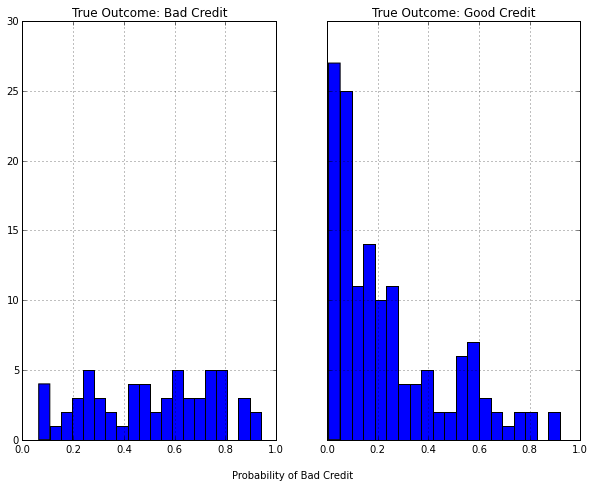

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, sharey=True)

ax1.hist(lreg_pred_prob[np.where(y_test == 'Bad'), 0].T, 20)
ax1.set_title('True Outcome: Bad Credit')

ax2.hist(lreg_pred_prob[np.where(y_test == 'Good'), 0].T, 20)
ax2.set_title('True Outcome: Good Credit')

fig.text(0.5, 0.06, 'Probability of Bad Credit', ha='center', va='center')

The probability of bad credit for the customers with good credit shows a skewed distribution where most customers' probabilities are quite low. In contrast, the probabilities for the customers with bad credit are flat (or uniformly distributed), reflecting the model's inability to distinguish bad credit cases.

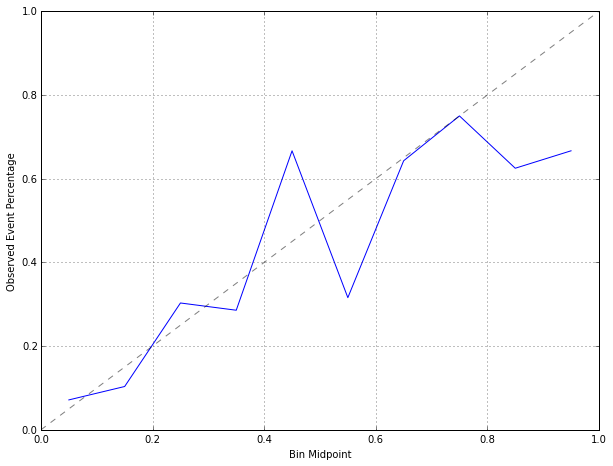

In [13]:
predict_counts = np.zeros([10])

for i in range(10):
    predict_counts[i] = np.mean(y_test[(lreg_pred_prob[:, 0] > i*0.1) * (lreg_pred_prob[:, 0] < (i+1)*0.1)] == 'Bad')
    
plt.plot(np.arange(0.05, 1.0, 0.1), predict_counts)
plt.plot([0, 1], [0, 1], 'k--', alpha = 0.5)
plt.xlabel("Bin Midpoint")
plt.ylabel("Observed Event Percentage")

The calibration plot shows the accuracy of the probability of bad credit degrades as it becomes larger to the point where a few samples with bad credit were predicted with a probability above 80%. This pattern is indicative of a model that has both poor calibration and poor performance.

When there are three or more classes, a heat map of the class probabilities can help gauge the confidence in the predictions.

### Equivocal Zones

An approach to improving classification performance is to create an equivocal or indeterminate zone where the class is not formally predicted when the confidence is not high. For a two-class problem that is nearly balanced in the response, the equivocal zone could be defined as $0.50 \pm z$. If z were 0.10, then samples with prediction probabilities between 0.40 and 0.60 would be called "equivocal". In this case, model performance would be calculated excluding the samples in the indeterminate zone. For data sets with more than 2 classes (C > 2), similar thresholds can be applied where the largest class probability must be larger than (1/C + z) to make a definitive prediction.

## 11.2 Evaluating Predicted Classes

A common method for describing the performance of a classification model is the *confusion matrix*. This is a simple cross-tabulation of the observed and predicted classes for the data.

Predict\Observe   | Event | Non-event
------------------|-------|----------
Event             | TP    |   FP
Non-event         | FN    |   TN

The above table shows an example when the outcome has two classes. Diagonal cells denote cases where the classes are correctly predicted while the off-diagonals illustrate the number of errors for each possible case.

The simplest metric is the overall accuracy rate. This reflects the agreement between the observed and predicted classes and has the most straightforward interpretation. However, there are a few disadvantages to using this statistic. First, overall accuracy counts make no distinction about the type of errors being made. In situations where the costs are different, accuracy may not measure the important model characteristics.

Second, one must consider the natural frequencies of each class. For example, in the USA, pregnant women routinely have blood drawn for alpha-fetoprotein testing, which attempts to detect genetic problems such as Down syndrome. Suppose the rate of this disorder in fetuses is approximately 1 in 800 or about one-tenth of on percent. A predictive model can achieve almost perfect accuracy by predicting all samples to be negative for Down syndrome.

What benchmark accuracy rate should be used to determine whether a model is performing adequantely? The no-information rate is the accuracy rate that can be achieved without a model. There are various ways to define this rate. For a data set with $C$ classes, the simplest definition, based on pure randomness, is $1/C$. However, this does not take into account the relative frequencies of the classes in the training set. An alternate definition of the no-information rate is the percentage of the largest class in the training set. Models with accuracy greater than this rate might be considered reasonable. The effect of severe class imbalances and some possible remedies are discussed later.

Rather than calculate the overall accuracy and compare it to the no-information rate, other metrics can be used that take into account the class distribution of the training set samples. The *Kappa statistic* takes into account the accuracy that would be generate simply by chance. $$Kappa = {O - E \over 1 - E}$$
where $O$ is the observed accuracy and $E$ is the expected accuracy based on the marginal totals of the confusion matrix. The statistic can take on values between -1 and 1; a value of 0 means there is no aggreement between the observed and predicted classes. Negative values indicate that the prediction is in the *opposite* direction of the truth, but large negative values seldom occur, if ever, when working with predictive models. When the class distributions are equivalent, overall accuracy and Kappa are proportional. Depending on the context, Kappa values within 0.3 to 0.5 indicate reasonable aggreement. Suppose the accuracy for a model is high (90%) but the expected accuracy is also high (85%), the Kappa statistic would show moderate aggreement (Kappa = 1/3) between the observed and predicted classes.

### Two-Class Problems

Consider the cases where there are two classes.

Predict\Observe   | Event | Non-event
------------------|-------|----------
Event             | TP    |   FP
Non-event         | FN    |   TN

The table shows the confusion matrix for generic classes "event" and "nonevent". The top row of the table corresponds to samples predicted to be events. Some are predicted correctly (the true positives, TP) while others are inaccurately classified (the false positives, FP). Similarly, the second row contains the predicted negatives with the true negatives (TN) and false nagatives (FN).

For two classes, there are additional statistics that may be relevant when one class is interpreted as the event of interest. The *sensitivity* of the model is the rate that the event of interest is predicted correctly for all samples having the event, i.e., 
$$Sensitivity = {\# \text{samples with the event and predicted to have the event} \over \# \text{samples having the event}} = {TP \over TP + FN}$$
The sensitivity is sometimes considered the *true positive rate* since it measures the accuracy in the event population. Conversely, the *specificity* is defined as the rate that nonevent samples are predicted as nonevents, i.e.
$$Specificity = {\# \text{samples without the event and predicted as non-events} \over \# \text{samples without the event}} = {TN \over TN + FP}$$
The *false positive rate* is defined as one minus the specificity. Assuming a fixed level of accuracy for the model, there is typically a trade-off to be made between the sensitivity and specificity. Intuitively, increasing the sensitivity of a model is likely to incur a loss of specificity, since more samples are being predicted as events. Potential trade-offs between sensitivity and specificity may be appropriate when there are different penalties associated with each type of error. The *receiver operating characteristic (ROC) curve* is one technique for evaluating this trade-off.

In [14]:
# pay a revisit to the credit data set
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, lreg_pred)

array([[ 31,  29],
       [ 25, 115]])

In [15]:
from __future__ import division

print "The overall accuracy: {0} and the no-information rate: {1}".format((31+115)/200, np.mean(y_test == 'Good'))
rnd_aggreement = ((31+29)/(200)) * ((31+25)/200) + ((25+115)/200)*((29+115)/200)
print "Kappa = {0:.4f}".format(((31+115)/200 - rnd_aggreement)/(1 - rnd_aggreement))
print "Sensitivity = {0:.4f}".format(31/(31+25))
print "Specificity = {0:.4f}".format(115/(115+29))

The overall accuracy: 0.73 and the no-information rate: 0.7
Kappa = 0.3447
Sensitivity = 0.5536
Specificity = 0.7986


Clearly, the model has trouble predicting when customers have bad credit. This is likely due to the imbalance of the classes and a lack of a strong predictor for bad credit.

Often, there is interest in having a single measure that reflects the false-positive and false-negative rates. Youden's J Index $$J = Sensitivity + Specificity - 1$$ measures the proportions of correctly predicted samples for both the event and non-event groups. In some contexts, this may be an appropriate method for summarizing the magnitude of both types of errors. The most common method for combining sensitivity and specificity into a single value uses the receiver operating characteristic (ROC) curve.

One often overlooked aspect of sensitivity and specificity is that they are conditional measures. Sensitivity is the accuracy rate for only the event population (and specificity for the non-events). Using the sensitivity and specificity, the obstetrician can make statements such as "assuming that the fetus does not have Down syndrome, the test has an accuracy of 95%." However, these statements might not be helpful to a patient since, for a new samples, all that known is the prediction. The person using the model prediction is typically interested in unconditional queries such as "what are the chances that the fetus has the genetic disorder?" This depends on three values: the sensitivity and specificity of the diagnostic test and the prevalence of the event in the population. Intuitively, if the event is rare, this should be reflected in the answer. Taking the prevalence into account, the analog to specificity is the *positive predicted value*, and the analog to specificity is the *negative predicted value*. These values make unconditional evaluations of the data. The positive predicted value answers the question "what is the probability that this sample is an event?" The formulas are 
$$PPV = {Sensitivity \times Prevalence \over (Sensitivity \times Prevalence) + ((1 - Specificity) \times (1 - Prevalence))}$$
$$NPV = {Specificity \times (1 - Prevalence) \over (Prevalence \times (1 - Sensitivity)) + (Specificity \times (1 - Prevalence))}$$

Clearly, the predictive values are nontrival combinations of performance and the rate of events. Predictive values are not often used to characterize the model. There are several reasons why, most of which are related to prevalence. First, prevalence is hard to quantify. Also, the prevalence is dynamic.

### Non-Accuracy-Based Criteria

For many commercial applications of predictive models, accuracy is not the primary goal for the model. Often, the purpose of the model might be to:
- Predict investment opportunities that maximize return
- Improve customer satisfaction by market segmentation
- Lower inventory costs by improving product demand forecasts
- Reduce costs associated with fraudulent transactions

While accuracy is important, it only describes how well the model predicts the data. If the model is fit for purpose, other more direct metrics of performance should be considered. These metrics quantify the consequences of correct and incorrect predictions.

## 11.3 Evaluating Class Probabilities

Class probabilities potentially offer more information about model predictions than the simple class value.

### Receiver Operating Characteristic (ROC) Curves

ROC curves were designed as a general method that, given a collection of continuous data points, determine an effective threshold such that values above the threshold are indicative of a specific event.

The ROC curve is created by evaluating the class probabilities for the model across a continuum of thresholds. For each candidate threshold, the resulting true-positive rate (i.e. the sensitivity) and the false-positive rate (one minus the specificity) are plotted against each other.

In [10]:
# ROC curve for credit data
from sklearn.metrics import roc_curve, auc

fpr, tpr, thres = roc_curve(y_test, lreg_pred_prob[:, 0], pos_label= 'Bad')
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)

# plot specific value based on threshold
fpr_50 = fpr[np.where(thres < 0.5)[0][0]]
tpr_50 = tpr[np.where(thres < 0.5)[0][0]]
plt.plot(fpr_50, tpr_50, 'o')
plt.text(fpr_50+0.02, tpr_50-0.01, 
         "0.500 (Spec = {0:.3f}, Sens = {1:.3f})".format(1-fpr_50, tpr_50))

fpr_30 = fpr[np.where(thres < 0.3)[0][0]]
tpr_30 = tpr[np.where(thres < 0.3)[0][0]]
plt.plot(fpr_30, tpr_30, 'o')
plt.text(fpr_30+0.02, tpr_30-0.01, 
         "0.300 (Spec = {0:.3f}, Sens = {1:.3f})".format(1-fpr_30, tpr_30))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity (False Positive Rate)')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

NameError: name 'y_test' is not defined

The green point is the default 50% threshold while the red point corresponds to the performance characteristics for a threshold of 30%. In this figure, the numbers in parentheses are $(specificity, sensitivity)$. Note that the trajectory of the curve between (0, 0) and the 50% threshold is steep, indicating that the sensitivity is increasing at a greater rate than the decrease in specificity. However, when the sensitivity is greater than 70%, there is a more significant decrease in specificity than the gain in sensitivity.

This plot is a helpful tool for choosing a threshold that appropriately maximizes the trade-off between sensitivity and specificity. However, altering the threshold only has the effect of making the samples more positive (or negative). In the confusion matrix, it cannot move samples out of both off-diagnoal table cells. There is almost always a decrease in either sensitivity or specificity.

The ROC curve can also be used for a quantitative assessment of the model. A perfect model that completely separates the two classes would have 100% sensitivity and specificity. Graphically, the ROC curve would be a single step between (0, 0) nad (0, 1) and remain constant from (0, 1) and (1, 1). The area under the ROC curve for such a model would be one. A completely ineffective model would result in an ROC curve that closely follows the $45^{\circ}$ diagnoal line and would have an area under the ROC curve of approximately 0.5. To visually compare different models, their ROC curves can be superimposed on the same graph. Comparing ROC curves can be useful in contrasting two or more models with different predictor sets (for the same model), differnt tuning parameters (within model comparisons), or complete different classifiers (between models).

The optimal model should be shifted towards the upper left corner of the plot. Alternatively, the model with the largest area under the ROC curve would be the most effective. 

One advantage of using ROC curves to characterize models is that, since it is a function of sensitivity and specificity, the curve is insensitive to disparities in the class proportions. A disadvantage of using the area under the curve to evaluate models is that it obscures information. When comparing models, it is common that no individual ROC curve is uniformly better than another. By summarizing these curves, there is a loss of information, especially if one particular area of the curve is of interest. The partial area under the ROC curve is an alternative that focuses on specific parts of the curve.

### Life Charts

Lift charts are a visualization tool for assessing the ability of a model to detect events in a data set with two classes. Suppose a group of samples with M events is scored using the event class probability. When ordered by the class probability, one would hope that the events are ranked higher than the non-events. Lift charts do just this: rank the samples by their scores and determine the cumulative event rate as more samples are evaluated. In the optimal case, the M highest-ranked samples would contain all M events. When the model is non-informative, the highest ranked X% of the data would contain, on average, X events. The *lift* is the number of samples detected by a model above a completely random selection of samples.

To construct the *lift charts* we would take the following steps:
1. Predict a set of samples that were not used in the model building process but have known outcomes.
2. Determine the baseline event rate, i.e. the percent of true events in the entire data set.
3. Order the data by the classification probability of the event of interest.
4. For each unique class probability value, calculate the percent of true events in all samples below the probability value.
5. Divide the percent of true events for each probability threshold by the baseline event rate.

The lift chart plots the cumulative gain/lift against the cumulative percentage of samples that have been screened. With a 50% event arte, the non-informative model has a curve that is close to the $45^{\circ}$ reference line, meaning that the model has no benefit for ranking samples.

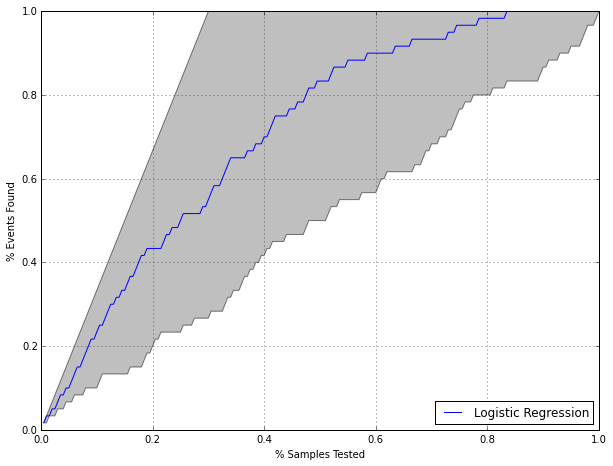

In [17]:
# lift chart for credit data
y_test_label = np.array(map(lambda c: 1 if c == 'Bad' else 0, y_test)).reshape(len(y_test), 1)
lift_curve = np.hstack((y_test_label, lreg_pred_prob[:, 0].reshape(len(y_test), 1)))
lift_curve = lift_curve[lift_curve[:, 1].argsort()[::-1]]

plt.plot(np.arange(1.0, len(y_test)+1)/len(y_test), 
         np.cumsum(lift_curve[:, 0])/np.sum(lift_curve[:, 0]),
         label = 'Logistic Regression')
plt.fill_between(np.arange(1.0, len(y_test)+1)/len(y_test), 
                 1.0*np.cumsum(y_test_label)/np.sum(y_test_label),
                 1.0*np.cumsum(np.random.permutation(y_test_label))/np.sum(y_test_label),
                 facecolor = 'gray', alpha = 0.5)
plt.legend(loc = 4)
plt.xlabel('% Samples Tested')
plt.ylabel('% Events Found')

Note that, since the event rate of the credit data is not balanced, the non-informative boundary is above the $45^{\circ}$ line.

Like ROC curves, the lift curves for different models can be compared to find the most appropriate model and the area under the curve can be used as a quantitative measure of performance. Also like ROC curves, some parts of the lift curve are of more interest than others. For example, the section of the curve associated with the highest-ranked samples should have an enriched true-positive rate and is likely to be the most important part of the curve.